Survey Data Analysis
===

In [1]:
import logging
import os
import string
import sys
from collections import Counter
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import scipy
import statsmodels.api as sm
import statsmodels.graphics.regressionplots
from tqdm import tqdm

import experiment.completion_utils
import experiment.generate
import experiment.guidance_conditions
import experiment.metrics
import experiment.qualtrics
from rag import prompt_utils, retrieval, retrieval_strategies

In [2]:
# width of the template column in inches (points / 72)
COLUMN_WIDTH_IN = 5.52062486111
DPI = 150

In [3]:
data_dir = Path("../data")
assert data_dir.exists()
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True)
assert figures_dir.exists()

In [4]:
dotenv.load_dotenv("../.env")
openai.api_key = os.environ["OPENAI_API_KEY"]
os.environ["OPENAI_API_KEY"][:3]

'sk-'

In [5]:
logging.basicConfig(format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO)
logger = logging.getLogger("SurveyDataAnalysis")
logger.info("Logging configured.")

2023-09-18 17:45:00,747 - SurveyDataAnalysis - INFO - Logging configured.


#### Constants and conditions

In [43]:
guidance_conditions = [
    "low",
    "high",
    #    "logit_bias",
]
corpus_conditions = [
    "math",
    "recipes",
    "none",
]

n_queries = 50
n_annotators = 3

relevance_answers = [
    "wrong",
    "topic",
    "partial",
    "perfect",
]
faithfulness_answers = [
    "none",
    "partial",
    "perfect",
]

In [ ]:
rng = np.random.default_rng(seed=7567313564)

In [ ]:
annotators = [{"annotator": i} for i in range(n_annotators)]
queries = [{"query": f"sample query {i}"} for i in range(n_queries)]
math_corpus = {"corpus": "math"}
recipes_corpus = {"corpus": "recipes"}
no_corpus = {"corpus": "none"}

## Mock data creation

Guidance:
 1. Low guidance
 2. High guidance
 3. logit_bias guidance

Corpus:
 1. Math textbook
 2. Recipes
 3. None

Queries (~50 of these, could get more)

Number of annotators...

For each Query X Corpus X Prompt:
 - For corpus == Math textbook, get one relevance judgment: Wrong, Topic, Partial, Perfect
 - Faithfulness judgment: Perfect, Partial, None
 - Quality: Excellent, Partial, Wrong?
 - OR this quality metric: pairwise comparison, with "both low quality", "both high quality"

Note: by definition, can't have different guidance conditions with no corpus. (Nothing to guide the answer to! Guidance only defined when using RAG)

We do pairwise comparions only for these guidance/corpus crosses:
 - Low/Math x High/Math (do human perceptions of faithfulness increase with high guidance prompts?) [Manipulation check]
   - Faithfulness: 
 - Low/Recipes x High/Recipes (is this necessary? this would be more manipulation checks...)
 - */None x */Recipes (no retrieval VS bad retrieval)
   - None x Low/Recipes x High/Recipes (is there a difference between these conditions in terms of correctness?)
     - I don't know how to do this from pairwise comparisons, statistically speaking...
   - None x */Recipes (does correctness drop when bad RAG is used?
   - None x Low/Recipes (does correctness drop LESS when low-guidance RAG is used?)
   - None x High/Recipes (does correctness drop MORE when high-guidance RAG is used?)
 - */None x */Math (no retrieval VS good retrieval)
 - High/Math x High/Math (stratified by retrieval relevance?)

In [7]:
# stage 1:
# generate relevance judgments
# for corpus_condition == "math"
ds = []
for query in queries:
    for annotator in annotators:
        relevance = rng.choice(relevance_answers, p=(0.1, 0.4, 0.3, 0.2))
        ds.append({"document": "Retrieved document text", "relevance": relevance, **math_corpus, **annotator, **query})
relevance_df = pd.DataFrame(ds)
relevance_df.sample(1)

,document,relevance,corpus,annotator,query
142,Retrieved document text,topic,math,1,sample query 47


In [8]:
relevance_df.relevance.value_counts()

relevance
topic      53
partial    49
perfect    37
wrong      11
Name: count, dtype: int64

In [9]:
relevance_df["relevance_level"] = relevance_df.relevance.map(lambda r: relevance_answers.index(r))
mean_relevance = relevance_df.groupby("query").relevance_level.mean().rename("mean_relevance")
relevance_df = (
    relevance_df.drop_duplicates(subset="query")
    .drop(columns=["annotator", "relevance", "relevance_level"])
    .join(mean_relevance, on="query")
    .reset_index(drop=True)
)
relevance_df.sample(n=1)

,document,corpus,query,mean_relevance
29,Retrieved document text,math,sample query 29,2.666667


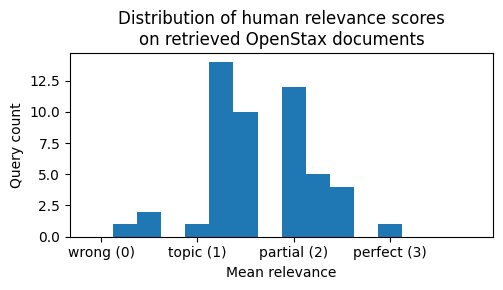

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

bin_width = 0.25
bins = np.arange(0, len(relevance_answers) + bin_width, bin_width)
ax.hist(relevance_df.mean_relevance, bins=bins, align="left")
ax.set_xticks(
    list(range(len(relevance_answers))), labels=[f"{answer} ({i})" for i, answer in enumerate(relevance_answers)]
)

ax.set_xlabel("Mean relevance")
ax.set_ylabel("Query count")
ax.set_title("Distribution of human relevance scores\non retrieved OpenStax documents")

fig.tight_layout()
plt.show()

In [11]:
# create the unannotated faithfulness df


def get_random_text(size: int = 10):
    choices = list(string.ascii_lowercase)
    return " ".join(np.random.choice(choices, size=size))


ds = []
for query in queries:
    for corpus in [math_corpus, recipes_corpus]:
        for guidance in guidance_conditions:
            document = "Retrieved document text\n" + "\n".join([get_random_text() for passage in range(4)])
            generation = (
                "Generated text " + get_random_text()
            )  # TODO do rag here, retrieved a document and generating a response

            for annotator in annotators:
                ds.append(
                    {
                        "generation": generation,
                        "document": document,
                        "guidance": guidance,
                        "faithfulness": "",
                        **corpus,
                        **annotator,
                        **query,
                    }
                )
unannotated_df = pd.DataFrame(ds)
print(len(unannotated_df))
unannotated_df.sample(1)

600


,generation,document,guidance,faithfulness,corpus,annotator,query
570,Generated text n a l m m p q a r y,Retrieved document text\ni v o q h z h b m o\n...,low,,recipes,0,sample query 47


In [255]:
# annotate for faithfulness
faithfulness_df = unannotated_df.copy()
print(faithfulness_answers)


def annotate_faithfulness(row):
    query = row.query
    document = row.document
    generation = row.generation
    guidance = row.guidance
    # this is where a human would use the elements to make an assessment
    if guidance == "low":
        faithfulness = rng.choice(faithfulness_answers, p=(0.2, 0.5, 0.3))
    else:
        faithfulness = rng.choice(faithfulness_answers, p=(0.1, 0.4, 0.5))
    return faithfulness


faithfulness_df["faithfulness"] = faithfulness_df.apply(annotate_faithfulness, axis=1)
faithfulness_df.sample(n=1)

['none', 'partial', 'perfect']


,generation,document,guidance,faithfulness,corpus,annotator,query
7,Generated text,Retrieved document text,low,partial,recipes,1,sample query 0


In [256]:
# do some annotator agreement disambiguation
# we could just take the mean of the level (0, 1, 2)
faithfulness_df["faithfulness_level"] = faithfulness_df.faithfulness.map(lambda f: faithfulness_answers.index(f))
group_keys = ["query", "corpus", "guidance"]
mean_faithfulness = faithfulness_df.groupby(group_keys).faithfulness_level.mean().rename("mean_faithfulness")
faithfulness_df = (
    faithfulness_df.drop_duplicates(subset=group_keys)
    .drop(columns=["annotator", "faithfulness", "faithfulness_level"])
    .join(mean_faithfulness, on=group_keys)
    .reset_index(drop=True)
)
faithfulness_df.sample(n=1)

,generation,document,guidance,corpus,query,mean_faithfulness
196,Generated text,Retrieved document text,low,math,sample query 49,1.333333


In [257]:
# now, merge in relevance to the unannotated_df
# pd.merge(faithfulness_df, relevance_df[["query", "mean_relevance"]], how="left", on=["query", "corpus"])
query_df = faithfulness_df.join(
    relevance_df[["query", "corpus", "mean_relevance"]].set_index(["query", "corpus"]),
    how="left",
    on=["query", "corpus"],
)
# by definition, recipes have no relevance to the queries
query_df.loc[query_df.corpus == "recipes", "mean_relevance"] = 0.0
assert query_df.mean_relevance.isna().sum() == 0
query_df.sort_values(by=["query", "guidance", "corpus"])
query_df.head(n=4)

,generation,document,guidance,corpus,query,mean_faithfulness,mean_relevance
0,Generated text,Retrieved document text,low,math,sample query 0,1.000000,1.0
1,Generated text,Retrieved document text,high,math,sample query 0,1.333333,1.0
2,Generated text,Retrieved document text,low,recipes,sample query 0,1.666667,0.0
3,Generated text,Retrieved document text,high,recipes,sample query 0,1.000000,0.0


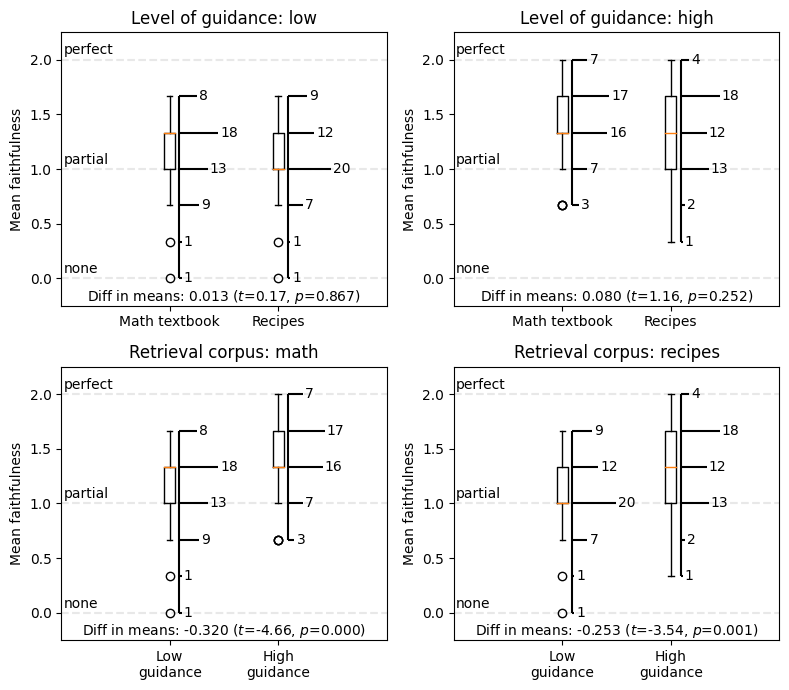

In [259]:
# compare faithfulness distribution between recipes and math corpus
# we hypothesize that faithfulness should be the same or slightly higher for math, but this doesn't really matter
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes = axes.reshape(-1)


def plot_faithfulness_comparison(ax, g1, g2, labels, title):
    box_width = 0.1
    ax.boxplot(
        [
            g1,
            g2,
        ],
        widths=box_width,
    )
    ax.set_xticks([1, 2], labels=labels)
    ax.set_ylabel("Mean faithfulness")
    ax.set_title(title)

    # two-sample t-test
    # this complex line of code works, but is not necessary since the dataframe is sorted by query
    # g1, g2 = zip(*query_df.groupby("query").apply(lambda group: (group[group.corpus == "math"].mean_faithfulness.iloc[0], group[group.corpus == "recipes"].mean_faithfulness.iloc[0])))
    g1, g2 = np.array(g1), np.array(g2)
    mean_diff = (g1 - g2).mean()
    t, p = scipy.stats.ttest_rel(g1, g2)
    # ax.text(1.5, min(g1.min(), g2.min()) - 0.05, f"Diff in means: {mean_diff:.3f} ($t$={t:.2f}, $p$={p:.3f})", ha="center", va="top")

    # ax.hist(g1, bins=20, orientation="horizontal", bottom=1, density=True)
    # np.histogram(g1, bins=bins
    for g, x in [(g1, 1), (g2, 2)]:
        xmin = x + (box_width / 2) + 0.04
        ax.vlines(xmin, ymin=g.min(), ymax=g.max(), color="black")
        for value, count in Counter(g).most_common():
            xmax = xmin + (count / len(g))
            ax.hlines(y=value, xmin=xmin, xmax=xmax, color="black")
            ax.text(x=xmax + 0.02, y=value, s=f"{count}", va="center", ha="left")

    ax.set_ylim(bottom=-0.25, top=2.25)
    ax.set_xlim(0, 3)
    ax.text(
        1.5, ax.get_ylim()[0], f"Diff in means: {mean_diff:.3f} ($t$={t:.2f}, $p$={p:.3f})", ha="center", va="bottom"
    )

    for i, answer in enumerate(faithfulness_answers):
        ax.axhline(i, color="lightgray", linestyle="--", alpha=0.5, zorder=-1)
        ax.text(ax.get_xlim()[0] + 0.02, i + 0.02, answer, ha="left", va="bottom")


for ax_ind, guidance in enumerate(["low", "high"]):
    ax = axes[ax_ind]
    labels = ["Math textbook", "Recipes"]
    g1 = query_df[(query_df.corpus == "math") & (query_df.guidance == guidance)].mean_faithfulness
    g2 = query_df[(query_df.corpus == "recipes") & (query_df.guidance == guidance)].mean_faithfulness
    title = f"Level of guidance: {guidance}"
    plot_faithfulness_comparison(ax, g1, g2, labels, title)

for ax_ind, corpus in enumerate(["math", "recipes"]):
    ax = axes[ax_ind + 2]
    labels = ["Low\nguidance", "High\nguidance"]
    g1 = query_df[(query_df.corpus == corpus) & (query_df.guidance == "low")].mean_faithfulness
    g2 = query_df[(query_df.corpus == corpus) & (query_df.guidance == "high")].mean_faithfulness
    title = f"Retrieval corpus: {corpus}"
    plot_faithfulness_comparison(ax, g1, g2, labels, title)

fig.tight_layout()
plt.show()

Level of guidance: low
                            OLS Regression Results                            
Dep. Variable:      mean_faithfulness   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.035
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.314
Time:                        14:34:59   Log-Likelihood:                -21.654
No. Observations:                  50   AIC:                             47.31
Df Residuals:                      48   BIC:                             51.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.

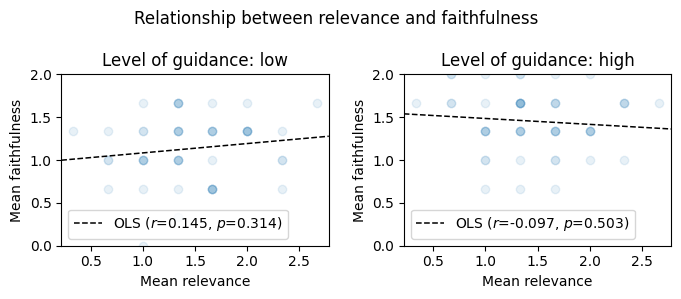

In [265]:
# explore correlation between relevance and faithfulness in the math corpus
# we would expect a small positive correlation
# when guidance is high, we expect a stronger correlation
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes = axes.reshape(-1)


def plot_relevance_vs_faithfulness(ax, sdf, title="", ylim=None):
    # correlation
    r, p = scipy.stats.pearsonr(sdf.mean_relevance, sdf.mean_faithfulness)
    # and the approximately equivalent linear regression
    # https://sebastianraschka.com/faq/docs/pearson-r-vs-linear-regr.html
    model = sm.OLS.from_formula(formula="mean_faithfulness ~ mean_relevance", data=sdf)
    model = model.fit()
    params = model.params

    # ax.hist2d(sdf.mean_relevance, sdf.mean_faithfulness, cmin=1)
    ax.scatter(sdf.mean_relevance, sdf.mean_faithfulness, alpha=0.1, marker="o")
    ax.set_xlabel("Mean relevance")
    ax.set_ylabel("Mean faithfulness")
    ax.set_title(title)

    if ylim:
        ax.set_ylim(ylim)

    statsmodels.graphics.regressionplots.abline_plot(
        model_results=model,
        ax=ax,
        color="black",
        linestyle="--",
        linewidth=1.1,
        label=f"OLS ($r$={r:.3f}, $p$={p:.3f})",
    )
    ax.legend()
    print(title)
    print(model.summary())


for ax_ind, guidance in enumerate(guidance_conditions):
    ax = axes[ax_ind]
    sdf = query_df[(query_df.corpus == "math") & (query_df.guidance == guidance)]
    title = f"Level of guidance: {guidance}"
    plot_relevance_vs_faithfulness(ax, sdf, title, ylim=(0, 2))

fig.suptitle("Relationship between relevance and faithfulness")

fig.tight_layout()
plt.show()

In [ ]:
# now create pairwise surveys
# most important: math/low vs math/high correctness

In [ ]:
# TODO could look for correlations here between automated metrics (like % of word overlap, and other more complex groundedness metrics)
# and human annotations of faithfulness

In [23]:
passages = ["Test text with extra."]
generation = "test text with extra words."
experiment_utils.metrics.compute_macro_f1(passages, generation)

0.9090909090909091

In [7]:
# create automated metric df


def get_random_text(size: int = 10):
    choices = list(string.ascii_lowercase)
    return " ".join(np.random.choice(choices, size=size))


corpus = math_corpus
ds = []
for query in queries:
    for guidance in ["A", "B", "C", "D", "E", "F"]:
        document = "Retrieved document text\n" + "\n".join([get_random_text() for passage in range(4)])
        generation = (
            "Generated text " + get_random_text()
        )  # TODO do rag here, retrieved a document and generating a response
        if guidance == "F":
            document += " a a a a a b b b b"
            generation += " a a a a a b b b b"
        ds.append({"generation": generation, "document": document, "guidance": guidance, **corpus, **query})
math_df = pd.DataFrame(ds)
print(len(math_df))
math_df.sample(1)

300


,generation,document,guidance,corpus,query
154,Generated text e a f c p f r z g k,Retrieved document text\nt n h r j c m c f x\n...,E,math,sample query 25


In [10]:
sdf = math_df[math_df.corpus == "math"]
# sdf = sdf.drop_duplicates(subset=["query", "generation", "document", "guidance"])
ds = []
for guidance, group in sdf.groupby("guidance"):
    assert group["query"].nunique() == len(group)
    f1_scores = []
    for row in group.itertuples():
        passages = document.split("\n")
        f1 = experiment.metrics.compute_macro_f1(passages, row.generation)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    macro_f1 = f1_scores.mean()
    # bootstrap confidence intervals
    bootstrap = scipy.stats.bootstrap((f1_scores,), np.mean, confidence_level=0.95, random_state=rng)
    ds.append(
        {
            "guidance": guidance,
            "macro_f1": macro_f1,
            "macro_f1_low": bootstrap.confidence_interval.low,
            "macro_f1_high": bootstrap.confidence_interval.high,
        }
    )
f1_df = pd.DataFrame(ds).sort_values(by="macro_f1", ascending=True)
f1_df

,guidance,macro_f1,macro_f1_low,macro_f1_high
3,D,0.421927,0.404139,0.441069
0,A,0.438886,0.415790,0.464270
1,B,0.439605,0.416518,0.462711
4,E,0.445563,0.420524,0.469068
2,C,0.455749,0.435010,0.476656
5,F,0.464326,0.439977,0.487834


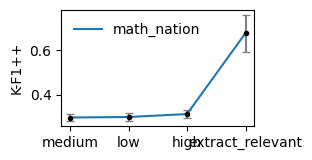

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3.2, 1.7))

metric = "macro_f1"
# copy = f1_df.copy()
# copy[[metric, metric + "_low", metric + "_high"]] += 0.1
# for query_set, metric_df in [("MN Geo", f1_df), ("MN PreA", copy)]:
for query_set, metric_df in f1_df.groupby("query_set"):
    assert metric in metric_df.columns
    xs = list(range(len(metric_df)))
    ys = metric_df[metric]
    yerr = metric_df[[metric + "_low", metric + "_high"]].subtract(metric_df[metric], axis=0).abs().T
    ax.scatter(xs, ys, color="black", marker=".")
    ax.errorbar(xs, ys, yerr=yerr, zorder=-1, capsize=3, ecolor="grey", label=query_set)

# legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, frameon=False, ncol=2)


ax.set_xticks(xs, labels=f1_df.guidance)
ax.set_ylabel("K-F1++")
# ax.set_ylim((0.2, 0.35))  # Consider manually setting the ylim

fig.tight_layout()
plt.show()

## Real data

#### Load query data

In [9]:
mn_general_student_queries_filepath = data_dir / "derived" / "mn_general_student_queries.csv"
query_df = pd.read_csv(mn_general_student_queries_filepath)
student_queries = [
    row.post_content.strip().replace("[Continued:]", "\n")
    for row in query_df.sample(frac=1, random_state=87896).itertuples()
    if row.is_respondable_query == "general"
]
len(student_queries)

51

In [10]:
query_df.subject_name.value_counts()

subject_name
Algebra 1      43
Geometry        9
Pre-Algebra     3
Name: count, dtype: int64

#### Retrieve documents

In [11]:
embedding_dir = data_dir / "derived" / "embeddings"
rori_db = retrieval.RetrievalDb(embedding_dir, "rori_microlesson", "db_string")
openstax_db = retrieval.RetrievalDb(embedding_dir, "openstax_subsection", "db_string")
recipe_db = retrieval.RetrievalDb(embedding_dir, "recipenlg", "db_string")

In [12]:
# create generations
openstax_subsection_db_info = retrieval.DbInfo(
    openstax_db,
    max_tokens=3000,
    max_texts=1,
    prefix="",
    use_parent_text=True,
    parent_group_cols=["chapter", "section"],
    parent_sort_cols=["index"],
)
openstax_retrieval_strategy = retrieval_strategies.MappedEmbeddingRetrievalStrategy(
    {
        "openstax_subsection_texts": openstax_subsection_db_info,
    },
)

corpus = math_corpus
ds = []
for query in student_queries:
    for guidance in experiment.guidance_conditions.guidance_condition_name_list:
        # TODO consider adding infrastructure to cache the messages and document
        prompt_manager = prompt_utils.PromptManager()
        prompt_manager.set_intro_messages(experiment.guidance_conditions.guidance_condition_messages_map[guidance])
        prompt_manager.set_retrieval_strategy(openstax_retrieval_strategy)
        messages = prompt_manager.build_query(query)
        document = prompt_manager.get_recent_slot_fill("openstax_subsection_texts")
        # assert document is not None, f"Couldn't find expected key in {prompt_manager.recent_slot_fill_dict}."
        ds.append(
            {
                "query_set": "math_nation",
                "query": query,
                "generation": "",
                "document": document,
                "guidance": guidance,
                "messages": messages,
                **corpus,
            }
        )
math_df = pd.DataFrame(ds)
print(len(math_df))
math_df.sample(1)

204


,query_set,query,generation,document,guidance,messages,corpus
149,math_nation,I know that this has been a consistent questio...,,Identify the Intercepts on a Graph: Every line...,low,"[{'role': 'system', 'content': 'You are going ...",math


In [13]:
# fill documents for the None retrieval condition
documents = (
    math_df.loc[math_df.document.notna(), ["query", "corpus", "document"]]
    .drop_duplicates(keep="first")
    .set_index("query")
)
math_df.loc[math_df.document.isna(), "document"] = list(
    documents.loc[math_df.loc[math_df.document.isna(), "query"]].document
)
assert math_df.document.isna().sum() == 0

#### Create or load relevance annotation for queries

In [14]:
query_df = math_df[(math_df.query_set == "math_nation") & (math_df.corpus == "math") & (math_df.guidance == "low")]
assert query_df["query"].nunique() == len(query_df)
query_df.sample(n=1)

,query_set,query,generation,document,guidance,messages,corpus
157,math_nation,Is supplementary angles are always adjacent,,Use the Properties of Angles: Are you familiar...,low,"[{'role': 'system', 'content': 'You are going ...",math


In [29]:
relevance_data_dir = data_dir / "derived" / "relevance"
relevance_data_dir.mkdir(exist_ok=True)
mn_relevance_filepath_1 = relevance_data_dir / "mn_set1_relevance.csv"
mn_relevance_filepath_1_filled = relevance_data_dir / "mn_set1_relevance_filled.csv"

In [ ]:
if not mn_relevance_filepath_1_filled.exists():
    query_df = query_df[["query_set", "corpus", "query", "document"]].reset_index(drop=True).sample(frac=1)
    query_df["relevance"] = ""

    def make_document_more_readable(doc):
        passages = doc.split("\n")
        return " - " + "\n - ".join(passages)

    query_df["document"] = query_df["document"].map(make_document_more_readable)
    query_df.to_csv(mn_relevance_filepath_1, index=False)
query_df.sample(n=1)

In [31]:
if mn_relevance_filepath_1_filled.exists():
    relevance_df = pd.read_csv(mn_relevance_filepath_1_filled)
relevance_df.sample(n=1)

,query_set,corpus,query,document,Zach,Chenglu,Wangda
46,math_nation,math,what is monomial,"- Identify Polynomials, Monomials, Binomials,...",Perfect,Perfect,Topic


In [39]:
def get_numeric_relevance(relevance_str):
    return relevance_answers.index(relevance_str.lower())


for annotator_name in ["Zach", "Chenglu", "Wangda"]:
    # relevance_df[annotator_name].map(get_numeric_relevance)
    print(relevance_df[annotator_name].value_counts())

Zach
Topic      23
Perfect    10
Partial     9
Wrong       9
Name: count, dtype: int64
Chenglu
Partial    14
Perfect    14
Topic      13
Wrong      10
Name: count, dtype: int64
Wangda
Wrong      17
Topic      13
Partial    12
Perfect     6
Name: count, dtype: int64


#### Create or load generations

In [15]:
corpus = experiment.generate.GenerationCorpus(data_dir / "derived", "math_corpus_test")
metadata_list = [row.to_dict() for _, row in math_df.iterrows()]
len(corpus.generations)

255

In [16]:
assert corpus.filter_generations() == 0

In [17]:
# conditionally remove
# corpus.filter_generations(should_remove_func=lambda generation: generation["guidance"] == "high")

In [17]:
len(corpus.generations)

255

In [18]:
nonmatching_generations = corpus.get_nonmatching_generations(metadata_list)
obsolete_df = pd.DataFrame(nonmatching_generations)
len(obsolete_df)

0

In [19]:
print(obsolete_df[["query_set", "query", "generation", "document", "guidance", "corpus"]].nunique())
obsolete_df.guidance.value_counts()

KeyError: "None of [Index(['query_set', 'query', 'generation', 'document', 'guidance', 'corpus'], dtype='object')] are in the [columns]"

In [ ]:
# remove non-matching from the generations list
_ = corpus.get_nonmatching_generations(metadata_list, should_remove_nonmatching=True)
len(corpus.generations)

In [23]:
# optionally, overwrite to forget deleted generations
corpus.overwrite()

In [20]:
# limiting factor is tokens per minute
# https://platform.openai.com/docs/guides/rate-limits/overview
max_tokens_per_minute = 90000

request_tokens = 4000
n_processes = 8
sleep_time = 16
request_time = 4 + sleep_time
process_tokens_per_minute = (request_tokens / request_time) * 60
tokens_per_minute = process_tokens_per_minute * n_processes
tokens_per_minute, tokens_per_minute / request_tokens  # approximate requests per minute

(96000.0, 24.0)

In [21]:
len(corpus.batch_filter_not_already_generated(metadata_list)), len(metadata_list)

(0, 204)

In [22]:
n_generated = corpus.batch_generate(
    metadata_list,
    n_processes=8,
    sleep=16.0,
    should_log_successful=True,
    request_timeout=40,
)
n_generated, len(corpus.generations)

(0, 255)

In [23]:
math_df = pd.DataFrame(corpus.generations)
print(len(math_df))
math_df = math_df.drop_duplicates(subset=["query_set", "query", "guidance", "corpus"], keep="last")
print(len(math_df))
math_df.sample(n=1)

255
204


,query_set,query,generation,document,guidance,messages,corpus
126,math_nation,what is the difference between communtative pr...,"According to the student's question, the most ...",Use the Commutative and Associative Properties...,extract_relevant,"[{'role': 'user', 'content': 'Given a middle-s...",math


In [24]:
math_df.guidance.value_counts()

guidance
low                 51
extract_relevant    51
none                51
high                51
Name: count, dtype: int64

In [25]:
verbose = False
if verbose:
    query_sample = np.random.choice(list(set(math_df["query"])), size=4, replace=False)
    for query, group in math_df[math_df["query"].isin(query_sample)].groupby("query"):
        print(f"=== {query} ===")
        print(group.iloc[0].document)
        for row in group.itertuples():
            print(f"+++ {row.guidance} +++")
            print(row.generation)
            print()
        print()

#### Save math_df

In [40]:
math_df.sample(n=1)

,query_set,query,generation,document,guidance,messages,corpus
187,math_nation,How do you find the zeros of a function by gra...,"To find the zeros of a function by graphing, y...",Plot Points on a Rectangular Coordinate System...,none,"[{'role': 'system', 'content': 'You are going ...",math


In [41]:
generations_dir = data_dir / "derived" / "generations"
generations_dir.mkdir(exist_ok=True)
math_df.to_csv(generations_dir / "math_df.csv", index=False)

#### Compute automated metrics

In [42]:
# load the data, if previously cached
generations_dir = data_dir / "derived" / "generations"
math_df = pd.read_csv(generations_dir / "math_df.csv")
math_df.sample(n=1)

,query_set,query,generation,document,guidance,messages,corpus
11,math_nation,What is a function notation?,Function notation is a way to represent a math...,Use Addition Notation: A college student has a...,low,"[{'role': 'system', 'content': 'You are going ...",math


In [25]:
assert experiment.metrics.get_bleurt_metric_object() is not None
assert experiment.metrics.get_bertscore_metric_object() is not None

2023-09-18 17:45:56,609 - evaluate_modules.metrics.evaluate-metric--bleurt.98e148b2f8c4a88aba5037e4e0e90c9fd9ec35dc37a054ded8cfef0fa801ffab.bleurt - WARNING - Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').


INFO:tensorflow:Reading checkpoint /Users/zacharylevonian/.cache/huggingface/metrics/bleurt/default/downloads/extracted/c344adb923f0c495f61e1f40865ccb4ce783ec9297c810bb96017735fbae8a91/bleurt-base-128.


2023-09-18 17:45:56,975 - tensorflow - INFO - Reading checkpoint /Users/zacharylevonian/.cache/huggingface/metrics/bleurt/default/downloads/extracted/c344adb923f0c495f61e1f40865ccb4ce783ec9297c810bb96017735fbae8a91/bleurt-base-128.


INFO:tensorflow:Config file found, reading.


2023-09-18 17:45:56,975 - tensorflow - INFO - Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


2023-09-18 17:45:56,976 - tensorflow - INFO - Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


2023-09-18 17:45:56,977 - tensorflow - INFO - Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


2023-09-18 17:45:56,977 - tensorflow - INFO - ... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


2023-09-18 17:45:56,978 - tensorflow - INFO - ... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


2023-09-18 17:45:56,978 - tensorflow - INFO - ... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


2023-09-18 17:45:56,979 - tensorflow - INFO - ... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


2023-09-18 17:45:56,980 - tensorflow - INFO - ... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


2023-09-18 17:45:56,980 - tensorflow - INFO - Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


2023-09-18 17:45:56,981 - tensorflow - INFO - Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


2023-09-18 17:45:57,024 - tensorflow - INFO - WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


2023-09-18 17:45:57,025 - tensorflow - INFO - Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


2023-09-18 17:45:57,025 - tensorflow - INFO - Loading model.
2023-09-18 17:45:58,077 - absl - INFO - Fingerprint not found. Saved model loading will continue.


INFO:tensorflow:BLEURT initialized.


2023-09-18 17:45:58,080 - tensorflow - INFO - BLEURT initialized.


In [26]:
use_bootstrap = True

sdf = math_df
assert sdf.query_set.nunique() == 1
ds = []
for guidance, group in sdf.groupby("guidance"):
    assert group["query"].nunique() == len(group)
    f1_scores = []
    bleurt_scores = []
    bertscore_scores = []
    for row in tqdm(group.itertuples(), desc=f"{guidance=}", total=len(group)):
        passages = row.document.split("\n")
        f1 = experiment.metrics.compute_macro_f1(passages, row.generation, discount_text=row.query)
        f1_scores.append(f1)
        bleurt = experiment.metrics.compute_bleurt(passages, row.generation)
        bleurt_scores.append(bleurt)
        bertscore = experiment.metrics.compute_bertscore(passages, row.generation)
        bertscore_scores.append(bertscore)
    f1_scores = np.array(f1_scores)
    bleurt_scores = np.array(bleurt_scores)
    bertscore_scores = np.array(bertscore_scores)
    macro_f1 = f1_scores.mean()
    if use_bootstrap:
        # bootstrap confidence intervals
        bootstrap = scipy.stats.bootstrap((f1_scores,), np.mean, confidence_level=0.95, random_state=rng)
        bleurt_bootstrap = scipy.stats.bootstrap((bleurt_scores,), np.mean, confidence_level=0.95, random_state=rng)
        bertscore_bootstrap = scipy.stats.bootstrap(
            (bertscore_scores,), np.mean, confidence_level=0.95, random_state=rng
        )
    else:
        # TODO do something more reasonable, e.g. the student's t approximation
        pass
    ds.append(
        {
            "guidance": guidance,
            "query_set": sdf.iloc[0].query_set,
            "macro_f1": macro_f1,
            "macro_f1_low": bootstrap.confidence_interval.low,
            "macro_f1_high": bootstrap.confidence_interval.high,
            "bleurt": bleurt_scores.mean(),
            "bleurt_low": bleurt_bootstrap.confidence_interval.low,
            "bleurt_high": bleurt_bootstrap.confidence_interval.high,
            "bertscore": bertscore_scores.mean(),
            "bertscore_low": bertscore_bootstrap.confidence_interval.low,
            "bertscore_high": bertscore_bootstrap.confidence_interval.high,
        }
    )
metric_df = pd.DataFrame(ds).sort_values(by="macro_f1", ascending=True)
metric_df

guidance='extract_relevant':   0%|                                                                                                | 0/51 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
guidance='none': 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:44<00:00,  2.05s/it]


,guidance,query_set,macro_f1,macro_f1_low,macro_f1_high,bleurt,bleurt_low,bleurt_high,bertscore,bertscore_low,bertscore_high
3,none,math_nation,0.270858,0.256018,0.287867,-0.571418,-0.620347,-0.525058,0.833733,0.831162,0.836603
2,low,math_nation,0.287759,0.269585,0.305522,-0.551136,-0.604130,-0.503332,0.836590,0.833371,0.839433
1,high,math_nation,0.355556,0.334545,0.377555,-0.464588,-0.525164,-0.409770,0.848702,0.844503,0.852855
0,extract_relevant,math_nation,0.672882,0.583256,0.755949,-0.480035,-0.613007,-0.349532,0.919088,0.903057,0.934254


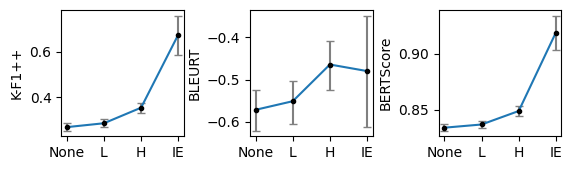

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(COLUMN_WIDTH_IN, 1.5))

metric_pretty_name_map = {
    "macro_f1": "K-F1++",
    "bleurt": "BLEURT",
    "bertscore": "BERTScore",
}

guidance_short_name_map = {
    "none": "None",
    "extract_relevant": "IE",
    "low": "L",
    "medium": "M",
    "high": "H",
}

for ax, metric in zip(axes, ["macro_f1", "bleurt", "bertscore"]):
    for query_set, mdf in metric_df.groupby("query_set"):
        assert metric in mdf.columns
        xs = list(range(len(mdf)))
        ys = mdf[metric]
        yerr = mdf[[metric + "_low", metric + "_high"]].subtract(mdf[metric], axis=0).abs().T
        ax.scatter(xs, ys, color="black", marker=".")
        ax.errorbar(xs, ys, yerr=yerr, zorder=-1, capsize=3, ecolor="grey", label=query_set)

    # legend
    # handles, labels = ax.get_legend_handles_labels()
    # handles = [h[0] for h in handles]
    # ax.legend(handles, labels, frameon=False, ncol=2)

    ax.set_xticks(xs, labels=[guidance_short_name_map[guidance] for guidance in metric_df.guidance])
    ax.set_ylabel(metric_pretty_name_map[metric])

fig.tight_layout(pad=0, w_pad=0.2)
fig.savefig(figures_dir / "guidance_autometrics.pdf", pad_inches=0, dpi=DPI)
plt.show()

#### Create qualtrics surveys

In [32]:
guidance_survey_set = {"none", "low", "high"}
survey_input_df = math_df[
    (math_df.query_set == "math_nation") & (math_df.corpus == "math") & (math_df.guidance.isin(guidance_survey_set))
]
len(survey_input_df)

153

In [33]:
qualtrics_template_filepath = data_dir / "raw" / "qualtrics" / "Rori_ranking_annotations_-_template.qsf"
survey_dir = data_dir / "derived" / "qualtrics"
assert qualtrics_template_filepath.exists()

In [34]:
template_survey_text = experiment.qualtrics.get_template(qualtrics_template_filepath)
survey_df = experiment.qualtrics.create_surveys(survey_input_df, template_survey_text, survey_dir)
len(survey_df)

51

In [35]:
survey_df.sample(n=1)

,query,document,response1,response2,response3,response1_meta,response2_meta,response3_meta,survey_id
23,How do you multiply fractions?!?!?,Simplify Fractions: In working with equivalent...,"To multiply fractions, you can multiply the nu...","Great question! To multiply fractions, you sim...","Great question! To multiply fractions, you nee...","{'query_set': 'math_nation', 'guidance': 'high...","{'query_set': 'math_nation', 'guidance': 'low'...","{'query_set': 'math_nation', 'guidance': 'none...",s_20230917_2/4


In [36]:
survey_df.survey_id.value_counts()

survey_id
s_20230917_1/4    15
s_20230917_2/4    15
s_20230917_3/4    15
s_20230917_4/4     6
Name: count, dtype: int64